In [8]:
# =====================================================
#     Tên: Real Estate Price Prediction
#     Nghiên cứu khoa học: "Nghiên cứu tối ưu mô hình kết hợp
#     trong việc dự đoán giá nhà tại Hà Nội"
#     Mô hình sử dụng: Linear Regression & XGBoost & Random Forest
# =====================================================

In [9]:
# -------------------------------------------------
# 0. CÀI THƯ VIỆN (Colab cài mới nhất đã hỗ trợ GPU)
# -------------------------------------------------
!pip install -U xgboost optuna --quiet

In [ ]:
# -------------------------------------------------
# 1. IMPORT & ĐỌC DỮ LIỆU
# -------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# --- tải/đọc CSV ---
DATA_PATH = Path("data_processing.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Không tìm thấy file: {DATA_PATH}")
data = pd.read_csv(DATA_PATH)

target = "price"
y = data[target]
X = data.drop(columns=[target])

In [11]:
# -------------------------------------------------
# 2. TIỀN XỬ LÝ: ColumnTransformer + Pipeline
# -------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_cols  = X.select_dtypes(include=["int64", "float64"]).columns
bool_cols = X.select_dtypes(include=["bool"]).columns  # 1‑hot district

preprocess = ColumnTransformer([
    ("num",  StandardScaler(),   num_cols),
    ("bool", "passthrough",      bool_cols)  # giữ nguyên 0/1
])

In [12]:
# -------------------------------------------------
# 3. ĐỊNH NGHĨA RMSLE & SCORER
# -------------------------------------------------
from sklearn.metrics import make_scorer, mean_squared_log_error

def rmsle(y_true, y_pred):
    # Cắt giá trị về >= 0 để tránh log(âm)
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Tạo scorer cho cross_val_score,
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [13]:
# -------------------------------------------------
# 4. TÁCH TRAIN / TEST (80 % / 20 %)
# -------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [14]:
# -------------------------------------------------
# 5. OPTUNA: TUNE XGBOOST GPU
# -------------------------------------------------
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "n_estimators"     : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"        : trial.suggest_int("max_depth", 4, 18),
        "learning_rate"    : trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample"        : trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma"            : trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha"        : trial.suggest_float("reg_alpha", 0.1, 10.0, log=True),
        "reg_lambda"       : trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "min_child_weight" : trial.suggest_float("min_child_weight", 1, 20),
        # --- BẬT GPU ---
        "tree_method"      : "gpu_hist",
        "predictor"        : "gpu_predictor",
        "gpu_id"           : 0,
        "random_state"     : 42,
    }

    model = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**params))
    ])

    # cross‑val 5 fold, tối thiểu RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-04-24 06:43:54,970] A new study created in memory with name: no-name-b26ca76b-8124-4f45-be90-8a934044371e


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:43:57] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:43:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:43:57] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:43:57] WARNING: /workspace/src/common

[I 2025-04-24 06:44:18,850] Trial 0 finished with value: 0.3384564324170472 and parameters: {'n_estimators': 616, 'max_depth': 11, 'learning_rate': 0.02475249768193218, 'subsample': 0.652874582965411, 'colsample_bytree': 0.6935305938948625, 'gamma': 4.487563896019392, 'reg_alpha': 0.9165586497047484, 'reg_lambda': 0.15257291282766247, 'min_child_weight': 4.06866736007799}. Best is trial 0 with value: 0.3384564324170472.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:

[I 2025-04-24 06:44:37,794] Trial 1 finished with value: 0.3242796790220736 and parameters: {'n_estimators': 1039, 'max_depth': 6, 'learning_rate': 0.02411261380185946, 'subsample': 0.6304644979397079, 'colsample_bytree': 0.9800684991793731, 'gamma': 3.4552587619665682, 'reg_alpha': 0.15758902522319032, 'reg_lambda': 0.10471115492618102, 'min_child_weight': 11.129997932902743}. Best is trial 1 with value: 0.3242796790220736.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:

[I 2025-04-24 06:44:59,369] Trial 2 finished with value: 0.26836299448756834 and parameters: {'n_estimators': 1015, 'max_depth': 7, 'learning_rate': 0.03714142307858496, 'subsample': 0.7684734488627588, 'colsample_bytree': 0.8890999299511175, 'gamma': 1.069446588169134, 'reg_alpha': 0.1568885043802082, 'reg_lambda': 2.3752248697752734, 'min_child_weight': 2.8465868317682386}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:

[I 2025-04-24 06:45:20,545] Trial 3 finished with value: 0.36392056674748485 and parameters: {'n_estimators': 1122, 'max_depth': 6, 'learning_rate': 0.1620867623487798, 'subsample': 0.89091399949082, 'colsample_bytree': 0.8562191567533595, 'gamma': 0.6871908208190441, 'reg_alpha': 6.903086093579564, 'reg_lambda': 0.14108162914455297, 'min_child_weight': 9.990000149923544}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:

[I 2025-04-24 06:45:54,262] Trial 4 finished with value: 0.4390449693216928 and parameters: {'n_estimators': 1009, 'max_depth': 12, 'learning_rate': 0.0339996346663019, 'subsample': 0.6792918005268768, 'colsample_bytree': 0.6604564229969013, 'gamma': 4.303926996110511, 'reg_alpha': 0.13562018855220356, 'reg_lambda': 1.5130227514724746, 'min_child_weight': 16.920674838013703}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:45:

[I 2025-04-24 06:46:15,991] Trial 5 finished with value: 0.4827867986153705 and parameters: {'n_estimators': 432, 'max_depth': 17, 'learning_rate': 0.08749477538253467, 'subsample': 0.7062402464824602, 'colsample_bytree': 0.7051845225956641, 'gamma': 1.9567328021375208, 'reg_alpha': 0.7522931309334594, 'reg_lambda': 0.16853871076607946, 'min_child_weight': 18.108026654925993}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:

[I 2025-04-24 06:46:36,946] Trial 6 finished with value: 0.3089023452717473 and parameters: {'n_estimators': 628, 'max_depth': 10, 'learning_rate': 0.05407093090390492, 'subsample': 0.8791448313973333, 'colsample_bytree': 0.6867529283854032, 'gamma': 1.9570783636266826, 'reg_alpha': 0.17140650170620023, 'reg_lambda': 0.2441976120570772, 'min_child_weight': 2.219455228385988}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:

[I 2025-04-24 06:46:53,786] Trial 7 finished with value: 0.4386518472131108 and parameters: {'n_estimators': 715, 'max_depth': 8, 'learning_rate': 0.25239044013492773, 'subsample': 0.7626273782979707, 'colsample_bytree': 0.874288729338491, 'gamma': 0.2802499134575953, 'reg_alpha': 0.8006227436257954, 'reg_lambda': 0.11081126477238865, 'min_child_weight': 13.922220476303716}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:46:

[I 2025-04-24 06:47:20,711] Trial 8 finished with value: 0.3624920914704138 and parameters: {'n_estimators': 510, 'max_depth': 18, 'learning_rate': 0.03509736572244622, 'subsample': 0.7288074829129845, 'colsample_bytree': 0.9094487472958213, 'gamma': 0.759036797425624, 'reg_alpha': 0.1892391964907324, 'reg_lambda': 1.3218755751299431, 'min_child_weight': 17.158704843431508}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:47:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:47:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:47:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:47:

[I 2025-04-24 06:48:02,232] Trial 9 finished with value: 0.3484210604300739 and parameters: {'n_estimators': 873, 'max_depth': 16, 'learning_rate': 0.0218134954377955, 'subsample': 0.8364301255213518, 'colsample_bytree': 0.9713213063383256, 'gamma': 3.4534850344821932, 'reg_alpha': 1.6338842951627177, 'reg_lambda': 0.20086848347119196, 'min_child_weight': 15.794531553499418}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:

[I 2025-04-24 06:48:22,271] Trial 10 finished with value: 0.3076535307738951 and parameters: {'n_estimators': 1453, 'max_depth': 4, 'learning_rate': 0.013188696835780639, 'subsample': 0.9904837408735715, 'colsample_bytree': 0.7895237980488974, 'gamma': 1.727935938434687, 'reg_alpha': 0.3457917029731578, 'reg_lambda': 5.195779968814732, 'min_child_weight': 5.705728144293567}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:

[I 2025-04-24 06:48:42,997] Trial 11 finished with value: 0.30960698395185526 and parameters: {'n_estimators': 1494, 'max_depth': 4, 'learning_rate': 0.011069096028287546, 'subsample': 0.996947671861191, 'colsample_bytree': 0.792528114872351, 'gamma': 1.434359267023729, 'reg_alpha': 0.37842234048314416, 'reg_lambda': 6.5249829154063725, 'min_child_weight': 5.963657706840786}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:48:

[I 2025-04-24 06:49:02,151] Trial 12 finished with value: 0.312251976311499 and parameters: {'n_estimators': 1381, 'max_depth': 4, 'learning_rate': 0.012114171003107443, 'subsample': 0.9900351103013336, 'colsample_bytree': 0.7813085256833641, 'gamma': 2.740771494249734, 'reg_alpha': 0.3692605700104438, 'reg_lambda': 6.0520211277276905, 'min_child_weight': 7.121187830107258}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:

[I 2025-04-24 06:49:29,390] Trial 13 finished with value: 0.27851158805037385 and parameters: {'n_estimators': 1251, 'max_depth': 7, 'learning_rate': 0.08154567210246919, 'subsample': 0.8052770376187808, 'colsample_bytree': 0.7585706099009665, 'gamma': 1.2912232088802484, 'reg_alpha': 0.370764315795686, 'reg_lambda': 2.7431706016006796, 'min_child_weight': 1.1593915709439593}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:

[I 2025-04-24 06:49:58,415] Trial 14 finished with value: 0.29743589079278165 and parameters: {'n_estimators': 1236, 'max_depth': 8, 'learning_rate': 0.08954079938148517, 'subsample': 0.7887413091082505, 'colsample_bytree': 0.6178915101919602, 'gamma': 1.0919040324004468, 'reg_alpha': 2.2658550065092937, 'reg_lambda': 2.1356999805663617, 'min_child_weight': 1.3108534008076307}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:49:

[I 2025-04-24 06:50:37,129] Trial 15 finished with value: 0.32132984341054593 and parameters: {'n_estimators': 1251, 'max_depth': 14, 'learning_rate': 0.07203491660445836, 'subsample': 0.830015711122096, 'colsample_bytree': 0.7354944995152376, 'gamma': 0.18881061240221086, 'reg_alpha': 0.1047887254735327, 'reg_lambda': 0.5221474376467711, 'min_child_weight': 1.0444981209774329}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:

[I 2025-04-24 06:50:57,848] Trial 16 finished with value: 0.3564393488331147 and parameters: {'n_estimators': 872, 'max_depth': 8, 'learning_rate': 0.14423029634969717, 'subsample': 0.9007062047360934, 'colsample_bytree': 0.8368658718635508, 'gamma': 2.625519353588973, 'reg_alpha': 0.27320490067702935, 'reg_lambda': 2.9630329642272994, 'min_child_weight': 8.74691635740966}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:50:

[I 2025-04-24 06:51:21,403] Trial 17 finished with value: 0.283318004451167 and parameters: {'n_estimators': 1264, 'max_depth': 6, 'learning_rate': 0.049706085457291375, 'subsample': 0.7507541809128844, 'colsample_bytree': 0.9208428174895479, 'gamma': 1.1998330806250952, 'reg_alpha': 0.5429887825876717, 'reg_lambda': 0.6104204643504489, 'min_child_weight': 3.9897295032481495}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:

[I 2025-04-24 06:51:44,111] Trial 18 finished with value: 0.32780339828609933 and parameters: {'n_estimators': 1123, 'max_depth': 9, 'learning_rate': 0.15354140925403054, 'subsample': 0.8335070547011697, 'colsample_bytree': 0.7532461414892955, 'gamma': 2.2403321937476366, 'reg_alpha': 2.19944879703011, 'reg_lambda': 3.0671138653484715, 'min_child_weight': 3.6335650945532265}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:

[I 2025-04-24 06:51:56,356] Trial 19 finished with value: 0.3409302729220819 and parameters: {'n_estimators': 303, 'max_depth': 13, 'learning_rate': 0.04264295275787598, 'subsample': 0.8086311671768411, 'colsample_bytree': 0.9303403255140944, 'gamma': 0.6550505242032483, 'reg_alpha': 4.960245802569615, 'reg_lambda': 0.6124993967990126, 'min_child_weight': 12.230937154669688}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:51:

[I 2025-04-24 06:52:16,236] Trial 20 finished with value: 0.3192255440198705 and parameters: {'n_estimators': 957, 'max_depth': 7, 'learning_rate': 0.0767188608872043, 'subsample': 0.9360285594627147, 'colsample_bytree': 0.826377489660935, 'gamma': 0.038027415518755436, 'reg_alpha': 0.25530555384555687, 'reg_lambda': 3.593638252729833, 'min_child_weight': 7.84979175938915}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:

[I 2025-04-24 06:52:40,093] Trial 21 finished with value: 0.2839145188636998 and parameters: {'n_estimators': 1288, 'max_depth': 6, 'learning_rate': 0.056073848238554734, 'subsample': 0.7557834653504979, 'colsample_bytree': 0.9072308344210772, 'gamma': 1.3243539610629294, 'reg_alpha': 0.5191098850111553, 'reg_lambda': 0.8438420731945732, 'min_child_weight': 3.490814382231622}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:52:

[I 2025-04-24 06:53:01,068] Trial 22 finished with value: 0.2905942516362733 and parameters: {'n_estimators': 1131, 'max_depth': 6, 'learning_rate': 0.052393579298663916, 'subsample': 0.7321469215438113, 'colsample_bytree': 0.9335632630005225, 'gamma': 1.074397802088519, 'reg_alpha': 0.5753026689264982, 'reg_lambda': 0.46548737031433773, 'min_child_weight': 4.83584727435074}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:

[I 2025-04-24 06:53:23,864] Trial 23 finished with value: 0.29840822584706406 and parameters: {'n_estimators': 1329, 'max_depth': 9, 'learning_rate': 0.12036375745297606, 'subsample': 0.7818169440352927, 'colsample_bytree': 0.8897529323353117, 'gamma': 1.5393201838414254, 'reg_alpha': 1.3730370318926273, 'reg_lambda': 0.33791008801673966, 'min_child_weight': 2.731270016462839}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:

[I 2025-04-24 06:53:43,188] Trial 24 finished with value: 0.289295520583818 and parameters: {'n_estimators': 1206, 'max_depth': 5, 'learning_rate': 0.033589332660430765, 'subsample': 0.7218285542821284, 'colsample_bytree': 0.9965208083526222, 'gamma': 0.9716067373150757, 'reg_alpha': 0.22194469476039724, 'reg_lambda': 9.131461267117794, 'min_child_weight': 6.178667116554616}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:53:

[I 2025-04-24 06:54:03,016] Trial 25 finished with value: 0.29424955319818247 and parameters: {'n_estimators': 790, 'max_depth': 10, 'learning_rate': 0.10842690982687948, 'subsample': 0.6918629284393564, 'colsample_bytree': 0.9447745466146167, 'gamma': 2.9246801623895182, 'reg_alpha': 0.4545708098651396, 'reg_lambda': 1.8645894456509815, 'min_child_weight': 2.1154447245819243}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:

[I 2025-04-24 06:54:31,630] Trial 26 finished with value: 0.2833020295165719 and parameters: {'n_estimators': 1384, 'max_depth': 7, 'learning_rate': 0.020037694931494498, 'subsample': 0.8661051313552259, 'colsample_bytree': 0.8211911842916167, 'gamma': 2.213484025473978, 'reg_alpha': 0.10813970430760331, 'reg_lambda': 1.0542738553513056, 'min_child_weight': 4.35786003534662}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:54:

[I 2025-04-24 06:55:00,531] Trial 27 finished with value: 0.2803767564677882 and parameters: {'n_estimators': 1401, 'max_depth': 7, 'learning_rate': 0.01758285997743872, 'subsample': 0.8577668423935635, 'colsample_bytree': 0.8235288658454284, 'gamma': 2.331179680829976, 'reg_alpha': 0.10710707202909783, 'reg_lambda': 0.9531590113757311, 'min_child_weight': 4.87428219033978}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:

[I 2025-04-24 06:55:38,200] Trial 28 finished with value: 0.27603844299600794 and parameters: {'n_estimators': 1173, 'max_depth': 10, 'learning_rate': 0.014316923951252227, 'subsample': 0.9291126621618984, 'colsample_bytree': 0.7406317042009414, 'gamma': 3.2741029443529586, 'reg_alpha': 0.13443682556736697, 'reg_lambda': 2.345270879259244, 'min_child_weight': 2.5835737178092133}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:55:

[I 2025-04-24 06:56:15,721] Trial 29 finished with value: 0.28419658366671735 and parameters: {'n_estimators': 1037, 'max_depth': 11, 'learning_rate': 0.01500528678406981, 'subsample': 0.9351812549485229, 'colsample_bytree': 0.7545608835754308, 'gamma': 4.871268596069121, 'reg_alpha': 0.25930377056144027, 'reg_lambda': 3.919767257429627, 'min_child_weight': 2.6875665968691793}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:

[I 2025-04-24 06:56:55,090] Trial 30 finished with value: 0.28283226313840404 and parameters: {'n_estimators': 1171, 'max_depth': 11, 'learning_rate': 0.026001296925379152, 'subsample': 0.9280956334884285, 'colsample_bytree': 0.7131055413070413, 'gamma': 3.31338225842023, 'reg_alpha': 0.14507348683683743, 'reg_lambda': 2.228370437724236, 'min_child_weight': 1.2080210045501931}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:

[I 2025-04-24 06:57:31,165] Trial 31 finished with value: 0.2998036987446585 and parameters: {'n_estimators': 1372, 'max_depth': 9, 'learning_rate': 0.01699317193801997, 'subsample': 0.8111865200499195, 'colsample_bytree': 0.767332706991688, 'gamma': 3.9437685865229892, 'reg_alpha': 0.10885911456745602, 'reg_lambda': 0.8830523046767764, 'min_child_weight': 4.95306277910642}. Best is trial 2 with value: 0.26836299448756834.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:

[I 2025-04-24 06:57:54,189] Trial 32 finished with value: 0.25308476838474747 and parameters: {'n_estimators': 1081, 'max_depth': 7, 'learning_rate': 0.010272119356365997, 'subsample': 0.8595176519140725, 'colsample_bytree': 0.8530888210651479, 'gamma': 3.0212444728038954, 'reg_alpha': 0.19402682148428427, 'reg_lambda': 1.4048022127726274, 'min_child_weight': 2.769519328593958}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:57:

[I 2025-04-24 06:58:09,425] Trial 33 finished with value: 0.271483321373575 and parameters: {'n_estimators': 938, 'max_depth': 5, 'learning_rate': 0.010314439149049413, 'subsample': 0.6089307750267734, 'colsample_bytree': 0.861628846094267, 'gamma': 3.148117774614701, 'reg_alpha': 0.1998409934560778, 'reg_lambda': 2.5494453750485, 'min_child_weight': 2.993795120125466}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:

[I 2025-04-24 06:58:24,777] Trial 34 finished with value: 0.3378247457517499 and parameters: {'n_estimators': 953, 'max_depth': 5, 'learning_rate': 0.010169150722173018, 'subsample': 0.6162753994376386, 'colsample_bytree': 0.8790703282957426, 'gamma': 3.103171587654194, 'reg_alpha': 0.19044153160608218, 'reg_lambda': 1.5192324050568164, 'min_child_weight': 19.988808845628114}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:

[I 2025-04-24 06:58:42,225] Trial 35 finished with value: 0.3062742442827557 and parameters: {'n_estimators': 1088, 'max_depth': 5, 'learning_rate': 0.013628581081046576, 'subsample': 0.6356696315462581, 'colsample_bytree': 0.8525917033539796, 'gamma': 3.7944375772511294, 'reg_alpha': 0.15257665672633342, 'reg_lambda': 4.625736156980751, 'min_child_weight': 9.907616063507088}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:58:

[I 2025-04-24 06:59:04,497] Trial 36 finished with value: 0.32930806295292153 and parameters: {'n_estimators': 783, 'max_depth': 10, 'learning_rate': 0.02613381922907377, 'subsample': 0.6547369426446046, 'colsample_bytree': 0.8601330400447181, 'gamma': 4.0745545591196635, 'reg_alpha': 0.14409508485867517, 'reg_lambda': 1.7387893630020026, 'min_child_weight': 7.15252407776784}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:

[I 2025-04-24 06:59:54,405] Trial 37 finished with value: 0.27652838656229617 and parameters: {'n_estimators': 976, 'max_depth': 13, 'learning_rate': 0.01022949316586875, 'subsample': 0.9035021915607695, 'colsample_bytree': 0.8120305983184422, 'gamma': 3.695824524458529, 'reg_alpha': 0.2095416278841586, 'reg_lambda': 2.4846409343460323, 'min_child_weight': 2.964307905689472}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:59:

[I 2025-04-24 07:00:18,978] Trial 38 finished with value: 0.3214029104889751 and parameters: {'n_estimators': 1052, 'max_depth': 8, 'learning_rate': 0.015403132557891809, 'subsample': 0.6684360447253461, 'colsample_bytree': 0.9548323510086836, 'gamma': 3.120960325025655, 'reg_alpha': 0.2577921597849934, 'reg_lambda': 1.2665266644522744, 'min_child_weight': 11.53588621710136}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:

[I 2025-04-24 07:00:32,863] Trial 39 finished with value: 0.2787428301847533 and parameters: {'n_estimators': 853, 'max_depth': 5, 'learning_rate': 0.018961640665857805, 'subsample': 0.9646412271308331, 'colsample_bytree': 0.6685449710827722, 'gamma': 2.742724463948991, 'reg_alpha': 0.13537487625705247, 'reg_lambda': 1.2090233573560891, 'min_child_weight': 2.2307446728659857}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:00:

[I 2025-04-24 07:01:07,026] Trial 40 finished with value: 0.33519236027507265 and parameters: {'n_estimators': 705, 'max_depth': 15, 'learning_rate': 0.023169607668330323, 'subsample': 0.9185837763100058, 'colsample_bytree': 0.8489438859197085, 'gamma': 4.487123369023093, 'reg_alpha': 0.16771658472723286, 'reg_lambda': 1.6286644609521226, 'min_child_weight': 8.531245556201483}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:

[I 2025-04-24 07:01:47,226] Trial 41 finished with value: 0.28272039467125154 and parameters: {'n_estimators': 967, 'max_depth': 12, 'learning_rate': 0.010237178226302353, 'subsample': 0.8821565534742288, 'colsample_bytree': 0.8129115191340637, 'gamma': 3.6888722098302043, 'reg_alpha': 0.20523166977763524, 'reg_lambda': 2.345046715973151, 'min_child_weight': 3.197360397782784}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:01:

[I 2025-04-24 07:02:33,487] Trial 42 finished with value: 0.26526617358108473 and parameters: {'n_estimators': 991, 'max_depth': 13, 'learning_rate': 0.01257705623284125, 'subsample': 0.956167763385797, 'colsample_bytree': 0.8870329843454713, 'gamma': 3.560935829916665, 'reg_alpha': 0.28354809477375637, 'reg_lambda': 3.890914033254986, 'min_child_weight': 2.1146962376068625}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:02:

[I 2025-04-24 07:03:22,288] Trial 43 finished with value: 0.293713482912244 and parameters: {'n_estimators': 1074, 'max_depth': 14, 'learning_rate': 0.012456408601212342, 'subsample': 0.959841584669714, 'colsample_bytree': 0.8967441920661834, 'gamma': 3.4009478387504704, 'reg_alpha': 0.3123977669635224, 'reg_lambda': 3.750861484567239, 'min_child_weight': 5.571249773198579}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:

[I 2025-04-24 07:03:36,000] Trial 44 finished with value: 0.29616792808682174 and parameters: {'n_estimators': 911, 'max_depth': 12, 'learning_rate': 0.21324054315872917, 'subsample': 0.973844064810255, 'colsample_bytree': 0.8710692871533754, 'gamma': 3.086910339048333, 'reg_alpha': 0.12143527018739445, 'reg_lambda': 4.821999249920043, 'min_child_weight': 2.245466353695787}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:03:

[I 2025-04-24 07:04:09,622] Trial 45 finished with value: 0.27214051012159785 and parameters: {'n_estimators': 1016, 'max_depth': 11, 'learning_rate': 0.014563051874630462, 'subsample': 0.8544836368259195, 'colsample_bytree': 0.8893488776827304, 'gamma': 2.4925725648760935, 'reg_alpha': 0.6990816331488703, 'reg_lambda': 7.431432555240858, 'min_child_weight': 3.788295005392215}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:

[I 2025-04-24 07:04:50,167] Trial 46 finished with value: 0.29794571495727806 and parameters: {'n_estimators': 817, 'max_depth': 16, 'learning_rate': 0.03034199204829783, 'subsample': 0.8571700121580481, 'colsample_bytree': 0.8886193918995334, 'gamma': 2.03444794196853, 'reg_alpha': 0.8611814036950298, 'reg_lambda': 9.159151911036348, 'min_child_weight': 4.151939777342772}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:04:

[I 2025-04-24 07:05:20,671] Trial 47 finished with value: 0.2935921369378529 and parameters: {'n_estimators': 710, 'max_depth': 14, 'learning_rate': 0.011945989461392366, 'subsample': 0.6076058322629736, 'colsample_bytree': 0.9161675402552535, 'gamma': 2.492459601354862, 'reg_alpha': 0.6616073028018672, 'reg_lambda': 7.28482238053237, 'min_child_weight': 6.4160726145557705}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:05:

[I 2025-04-24 07:06:13,839] Trial 48 finished with value: 0.34488515768117234 and parameters: {'n_estimators': 1006, 'max_depth': 18, 'learning_rate': 0.012297073650098349, 'subsample': 0.8676610349184167, 'colsample_bytree': 0.8676266404205976, 'gamma': 4.22489836679712, 'reg_alpha': 1.1189557570976632, 'reg_lambda': 7.021270691057653, 'min_child_weight': 14.378643188127196}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:

[I 2025-04-24 07:06:26,762] Trial 49 finished with value: 0.28484249531081274 and parameters: {'n_estimators': 925, 'max_depth': 4, 'learning_rate': 0.015807200409638084, 'subsample': 0.7747406931702958, 'colsample_bytree': 0.840104895119318, 'gamma': 2.87488917378848, 'reg_alpha': 0.322480858635484, 'reg_lambda': 3.092810323593847, 'min_child_weight': 1.858876301954897}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:06:

[I 2025-04-24 07:07:02,934] Trial 50 finished with value: 0.2760892978439199 and parameters: {'n_estimators': 1006, 'max_depth': 12, 'learning_rate': 0.02257285106135492, 'subsample': 0.82527857539816, 'colsample_bytree': 0.9059656179351189, 'gamma': 3.588875316526131, 'reg_alpha': 0.4676877673435363, 'reg_lambda': 5.426056769092352, 'min_child_weight': 3.7914850918844296}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:

[I 2025-04-24 07:07:59,185] Trial 51 finished with value: 0.2556376702036182 and parameters: {'n_estimators': 1160, 'max_depth': 13, 'learning_rate': 0.013509273929280155, 'subsample': 0.9035196972990052, 'colsample_bytree': 0.8810475387311025, 'gamma': 3.2449672141098365, 'reg_alpha': 0.19044965407684375, 'reg_lambda': 2.0501447882806922, 'min_child_weight': 1.7448774802901919}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:07:

[I 2025-04-24 07:08:55,049] Trial 52 finished with value: 0.25586302036183295 and parameters: {'n_estimators': 1098, 'max_depth': 13, 'learning_rate': 0.011332201977985292, 'subsample': 0.898455317922419, 'colsample_bytree': 0.8814842977217018, 'gamma': 3.5055819940111848, 'reg_alpha': 0.16959492786693758, 'reg_lambda': 2.0467087442800524, 'min_child_weight': 1.8131586007812608}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:08:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:08:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:08:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:08:

[I 2025-04-24 07:09:52,100] Trial 53 finished with value: 0.2589175160519629 and parameters: {'n_estimators': 1114, 'max_depth': 13, 'learning_rate': 0.011344440461851069, 'subsample': 0.8999432444604853, 'colsample_bytree': 0.8758030165447213, 'gamma': 3.9856983142186055, 'reg_alpha': 0.19221474660417742, 'reg_lambda': 2.106606190418359, 'min_child_weight': 1.7269612010832338}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:09:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:09:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:09:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:09:

[I 2025-04-24 07:10:49,480] Trial 54 finished with value: 0.26301900004004775 and parameters: {'n_estimators': 1133, 'max_depth': 13, 'learning_rate': 0.012615459495743013, 'subsample': 0.893514497450048, 'colsample_bytree': 0.8398729125812545, 'gamma': 3.898656618819273, 'reg_alpha': 0.1594696709527772, 'reg_lambda': 1.7755894685657585, 'min_child_weight': 1.7189415954419807}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:10:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:10:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:10:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:10:

[I 2025-04-24 07:11:46,874] Trial 55 finished with value: 0.2627566142180948 and parameters: {'n_estimators': 1106, 'max_depth': 13, 'learning_rate': 0.011672611890367186, 'subsample': 0.908572176646015, 'colsample_bytree': 0.8360628860262317, 'gamma': 3.964504378647061, 'reg_alpha': 0.1629650108226376, 'reg_lambda': 1.9836266376326022, 'min_child_weight': 1.652198770120266}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:11:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:11:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:11:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:11:

[I 2025-04-24 07:13:01,786] Trial 56 finished with value: 0.2760763888851655 and parameters: {'n_estimators': 1173, 'max_depth': 15, 'learning_rate': 0.011450668939593116, 'subsample': 0.898314136228885, 'colsample_bytree': 0.7997677056065549, 'gamma': 4.717184007162193, 'reg_alpha': 0.16635940438497956, 'reg_lambda': 1.9581143892194444, 'min_child_weight': 1.5290925250457088}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:13:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:13:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:13:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:13:

[I 2025-04-24 07:13:51,243] Trial 57 finished with value: 0.2673533880685005 and parameters: {'n_estimators': 1144, 'max_depth': 14, 'learning_rate': 0.019412384199611773, 'subsample': 0.9114044503733846, 'colsample_bytree': 0.8395765536799987, 'gamma': 3.910765662349288, 'reg_alpha': 0.22390023916626994, 'reg_lambda': 1.5006132594973491, 'min_child_weight': 1.0951253736834834}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:13:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:13:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:13:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:13:

[I 2025-04-24 07:14:46,760] Trial 58 finished with value: 0.2813576213157526 and parameters: {'n_estimators': 1102, 'max_depth': 13, 'learning_rate': 0.013501011359662436, 'subsample': 0.8828914379640926, 'colsample_bytree': 0.7855259670601556, 'gamma': 4.382508506021814, 'reg_alpha': 7.581033558930601, 'reg_lambda': 0.7514797034365845, 'min_child_weight': 1.7126381439934872}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:14:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:14:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:14:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:14:

[I 2025-04-24 07:15:48,796] Trial 59 finished with value: 0.2954278454000565 and parameters: {'n_estimators': 1223, 'max_depth': 15, 'learning_rate': 0.017044799851494867, 'subsample': 0.9498706672993983, 'colsample_bytree': 0.8376023579260803, 'gamma': 4.1934717071555445, 'reg_alpha': 0.17776536479968919, 'reg_lambda': 1.0990815741610398, 'min_child_weight': 3.199673299750276}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:15:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:15:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:15:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:15:

[I 2025-04-24 07:16:47,299] Trial 60 finished with value: 0.2692889774777348 and parameters: {'n_estimators': 1304, 'max_depth': 12, 'learning_rate': 0.011512793083226652, 'subsample': 0.8453483382918827, 'colsample_bytree': 0.8091945709247605, 'gamma': 4.6505612176031645, 'reg_alpha': 0.3936721741980475, 'reg_lambda': 1.3828842492193254, 'min_child_weight': 1.0419461942350812}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:16:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:16:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:16:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:16:

[I 2025-04-24 07:17:41,002] Trial 61 finished with value: 0.26168574268306627 and parameters: {'n_estimators': 1069, 'max_depth': 13, 'learning_rate': 0.013279873258706863, 'subsample': 0.8870164211437044, 'colsample_bytree': 0.8790951440221256, 'gamma': 3.559689519425742, 'reg_alpha': 0.22973591829202838, 'reg_lambda': 1.926432680778326, 'min_child_weight': 1.8447138408209756}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:17:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:17:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:17:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:17:

[I 2025-04-24 07:18:35,020] Trial 62 finished with value: 0.2651521694146954 and parameters: {'n_estimators': 1068, 'max_depth': 13, 'learning_rate': 0.013163013132948516, 'subsample': 0.8915259356628064, 'colsample_bytree': 0.8508757532895521, 'gamma': 4.037973087236289, 'reg_alpha': 0.23105278140309343, 'reg_lambda': 1.8962437767085103, 'min_child_weight': 1.6853088464179105}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:18:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:18:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:18:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:18:

[I 2025-04-24 07:19:34,331] Trial 63 finished with value: 0.2754814004087676 and parameters: {'n_estimators': 1210, 'max_depth': 14, 'learning_rate': 0.01591448191874568, 'subsample': 0.915866169855203, 'colsample_bytree': 0.874759234370146, 'gamma': 3.469683650449075, 'reg_alpha': 0.1283430715876719, 'reg_lambda': 2.974929516392845, 'min_child_weight': 2.5126541254797656}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:19:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:19:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:19:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:19:

[I 2025-04-24 07:20:16,668] Trial 64 finished with value: 0.27808379475837475 and parameters: {'n_estimators': 1130, 'max_depth': 12, 'learning_rate': 0.01164672458778103, 'subsample': 0.8770633951942599, 'colsample_bytree': 0.9252841208928093, 'gamma': 3.8181948174717886, 'reg_alpha': 0.17345993661301604, 'reg_lambda': 2.0843616946883503, 'min_child_weight': 4.414200751464572}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:20:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:20:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:20:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:20:

[I 2025-04-24 07:21:07,969] Trial 65 finished with value: 0.27838937506380196 and parameters: {'n_estimators': 1171, 'max_depth': 13, 'learning_rate': 0.011066062691858414, 'subsample': 0.9404717508039749, 'colsample_bytree': 0.9019407939092839, 'gamma': 2.942155935906803, 'reg_alpha': 9.501813597480869, 'reg_lambda': 1.698235750340695, 'min_child_weight': 3.401481341031788}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:21:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:21:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:21:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:21:

[I 2025-04-24 07:22:18,131] Trial 66 finished with value: 0.2767157647392525 and parameters: {'n_estimators': 1048, 'max_depth': 16, 'learning_rate': 0.014043255495183087, 'subsample': 0.9053487294701579, 'colsample_bytree': 0.8291385659172299, 'gamma': 3.358033453815141, 'reg_alpha': 0.282409340756426, 'reg_lambda': 1.368614322645798, 'min_child_weight': 1.8001896398081594}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:22:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:22:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:22:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:22:

[I 2025-04-24 07:22:53,564] Trial 67 finished with value: 0.29026576811255433 and parameters: {'n_estimators': 1105, 'max_depth': 11, 'learning_rate': 0.020833364077419918, 'subsample': 0.8729830020175122, 'colsample_bytree': 0.9424597165420779, 'gamma': 4.102351668919212, 'reg_alpha': 0.11957716546030905, 'reg_lambda': 1.16158165977737, 'min_child_weight': 5.172391594098225}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:22:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:22:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:22:

[I 2025-04-24 07:23:52,836] Trial 68 finished with value: 0.27982218208413084 and parameters: {'n_estimators': 1261, 'max_depth': 14, 'learning_rate': 0.017996680647910667, 'subsample': 0.893376616046783, 'colsample_bytree': 0.8772464441852055, 'gamma': 3.6378862157865477, 'reg_alpha': 0.2372560004764059, 'reg_lambda': 2.7587688905727226, 'min_child_weight': 2.6067651236237284}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:23:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:23:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:23:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:23:

[I 2025-04-24 07:24:21,840] Trial 69 finished with value: 0.27003160834843687 and parameters: {'n_estimators': 1200, 'max_depth': 13, 'learning_rate': 0.06373246078188384, 'subsample': 0.8418970616245095, 'colsample_bytree': 0.8606467041724571, 'gamma': 3.2372782857238374, 'reg_alpha': 0.15369436287191035, 'reg_lambda': 3.319938875968136, 'min_child_weight': 1.619003840586565}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:24:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:24:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:24:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:24:

[I 2025-04-24 07:25:36,319] Trial 70 finished with value: 0.3123885625455943 and parameters: {'n_estimators': 1334, 'max_depth': 15, 'learning_rate': 0.010061455849045503, 'subsample': 0.9210896339970576, 'colsample_bytree': 0.7739523951173168, 'gamma': 3.8219181638036708, 'reg_alpha': 0.18988304407936635, 'reg_lambda': 2.1389776473738333, 'min_child_weight': 4.154740489611417}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:25:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:25:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:25:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:25:

[I 2025-04-24 07:26:29,957] Trial 71 finished with value: 0.2647262250836602 and parameters: {'n_estimators': 1071, 'max_depth': 13, 'learning_rate': 0.013648640087051946, 'subsample': 0.8924439345816582, 'colsample_bytree': 0.8494458917003002, 'gamma': 4.023474533037024, 'reg_alpha': 0.2200049702923026, 'reg_lambda': 1.9025204252349268, 'min_child_weight': 1.785753010844926}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:26:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:26:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:26:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:26:

[I 2025-04-24 07:27:20,719] Trial 72 finished with value: 0.26077842286456365 and parameters: {'n_estimators': 1152, 'max_depth': 12, 'learning_rate': 0.013190679577687565, 'subsample': 0.8872100773422446, 'colsample_bytree': 0.8481278244881182, 'gamma': 4.344350919629116, 'reg_alpha': 0.2983526782959561, 'reg_lambda': 1.789711914133004, 'min_child_weight': 1.082581353591702}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:27:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:27:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:27:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:27:

[I 2025-04-24 07:28:10,659] Trial 73 finished with value: 0.2752583092734217 and parameters: {'n_estimators': 1146, 'max_depth': 12, 'learning_rate': 0.011097426371874547, 'subsample': 0.9439184595414034, 'colsample_bytree': 0.8247006613282539, 'gamma': 4.4779899467266215, 'reg_alpha': 2.914056688807474, 'reg_lambda': 1.5304445306009486, 'min_child_weight': 2.472033583715935}. Best is trial 32 with value: 0.25308476838474747.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:28:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:28:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:28:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:28:

[I 2025-04-24 07:29:01,194] Trial 74 finished with value: 0.2509813231258066 and parameters: {'n_estimators': 1036, 'max_depth': 14, 'learning_rate': 0.016466295824017377, 'subsample': 0.9230808583644698, 'colsample_bytree': 0.9136817301749893, 'gamma': 4.298044609034276, 'reg_alpha': 0.10050583070309323, 'reg_lambda': 2.562200205402697, 'min_child_weight': 1.1592581636652048}. Best is trial 74 with value: 0.2509813231258066.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:29:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:29:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:29:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:29:

[I 2025-04-24 07:29:53,626] Trial 75 finished with value: 0.25422713434865457 and parameters: {'n_estimators': 1047, 'max_depth': 14, 'learning_rate': 0.01618712185100461, 'subsample': 0.9233720873617782, 'colsample_bytree': 0.8990825291258481, 'gamma': 4.334812150551318, 'reg_alpha': 0.10690309819094067, 'reg_lambda': 2.6444360305873076, 'min_child_weight': 1.0908962106694702}. Best is trial 74 with value: 0.2509813231258066.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:29:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:29:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:29:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:29:

[I 2025-04-24 07:30:42,400] Trial 76 finished with value: 0.24289205672376105 and parameters: {'n_estimators': 1049, 'max_depth': 14, 'learning_rate': 0.016898605357046504, 'subsample': 0.9267025231953024, 'colsample_bytree': 0.9626970216927299, 'gamma': 4.944842180570478, 'reg_alpha': 0.11466970225986374, 'reg_lambda': 2.6234799284955725, 'min_child_weight': 1.1705946633597055}. Best is trial 76 with value: 0.24289205672376105.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:30:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:30:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:30:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:30:

[I 2025-04-24 07:31:29,830] Trial 77 finished with value: 0.25128762615262235 and parameters: {'n_estimators': 1035, 'max_depth': 14, 'learning_rate': 0.01670126471731095, 'subsample': 0.9827435558573144, 'colsample_bytree': 0.912510267963197, 'gamma': 4.989095391347119, 'reg_alpha': 0.10369081667955742, 'reg_lambda': 2.494657847685926, 'min_child_weight': 1.058524718176726}. Best is trial 76 with value: 0.24289205672376105.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:31:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:31:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:31:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:31:

[I 2025-04-24 07:32:07,201] Trial 78 finished with value: 0.2792052557081031 and parameters: {'n_estimators': 886, 'max_depth': 15, 'learning_rate': 0.028649662270108688, 'subsample': 0.9927055649146047, 'colsample_bytree': 0.9628856579609805, 'gamma': 4.808504180362174, 'reg_alpha': 0.1014879605484702, 'reg_lambda': 2.546417789479187, 'min_child_weight': 3.2904371043112755}. Best is trial 76 with value: 0.24289205672376105.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:32:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:32:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:32:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:32:

[I 2025-04-24 07:32:37,757] Trial 79 finished with value: 0.25899973190326697 and parameters: {'n_estimators': 1025, 'max_depth': 14, 'learning_rate': 0.040289985651357135, 'subsample': 0.983580586276316, 'colsample_bytree': 0.9907151687988621, 'gamma': 4.978178511358805, 'reg_alpha': 0.11856911624254445, 'reg_lambda': 4.196647533725712, 'min_child_weight': 2.8108160317407687}. Best is trial 76 with value: 0.24289205672376105.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:32:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:32:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:32:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:32:

[I 2025-04-24 07:33:11,750] Trial 80 finished with value: 0.26132143619545506 and parameters: {'n_estimators': 550, 'max_depth': 16, 'learning_rate': 0.0182637392769355, 'subsample': 0.9267574198818452, 'colsample_bytree': 0.9421074364708696, 'gamma': 4.636265976590301, 'reg_alpha': 0.10215616434446005, 'reg_lambda': 3.272041034839061, 'min_child_weight': 2.299354797485573}. Best is trial 76 with value: 0.24289205672376105.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:33:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:33:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:33:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:33:

[I 2025-04-24 07:33:41,530] Trial 81 finished with value: 0.26322086724599814 and parameters: {'n_estimators': 1023, 'max_depth': 14, 'learning_rate': 0.04239631668032063, 'subsample': 0.9843615650102763, 'colsample_bytree': 0.9711923579606991, 'gamma': 4.9342783407477535, 'reg_alpha': 0.11752331525276505, 'reg_lambda': 4.130101688746043, 'min_child_weight': 2.8550188664482095}. Best is trial 76 with value: 0.24289205672376105.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:33:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:33:

[I 2025-04-24 07:34:29,216] Trial 82 finished with value: 0.24099330049136594 and parameters: {'n_estimators': 1037, 'max_depth': 14, 'learning_rate': 0.01623455670103977, 'subsample': 0.953815700230925, 'colsample_bytree': 0.9958130331548645, 'gamma': 4.994692926393433, 'reg_alpha': 0.13307605359229097, 'reg_lambda': 2.78580556294036, 'min_child_weight': 1.1971864541945474}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:34:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:34:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:34:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:34:

[I 2025-04-24 07:35:20,118] Trial 83 finished with value: 0.24985043362527745 and parameters: {'n_estimators': 974, 'max_depth': 15, 'learning_rate': 0.01657088445071775, 'subsample': 0.9721748030468075, 'colsample_bytree': 0.9143565897940709, 'gamma': 4.712995033369408, 'reg_alpha': 0.1367223059186481, 'reg_lambda': 2.6927190999489734, 'min_child_weight': 1.1558654667371047}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:35:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:35:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:35:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:35:

[I 2025-04-24 07:36:08,060] Trial 84 finished with value: 0.24182891955319227 and parameters: {'n_estimators': 977, 'max_depth': 15, 'learning_rate': 0.016553514342042892, 'subsample': 0.9759835507829243, 'colsample_bytree': 0.979256632356219, 'gamma': 4.755302243455905, 'reg_alpha': 0.13671887114443398, 'reg_lambda': 2.699370807368458, 'min_child_weight': 1.0147112910744556}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:36:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:36:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:36:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:36:

[I 2025-04-24 07:36:46,646] Trial 85 finished with value: 0.24409819974427105 and parameters: {'n_estimators': 971, 'max_depth': 16, 'learning_rate': 0.024667196048975618, 'subsample': 0.9703843400980787, 'colsample_bytree': 0.9803664442419325, 'gamma': 4.768200930546539, 'reg_alpha': 0.14133280841672136, 'reg_lambda': 2.7656414053726452, 'min_child_weight': 1.018551407141089}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:36:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:36:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:36:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:36:

[I 2025-04-24 07:37:26,702] Trial 86 finished with value: 0.24350049228295806 and parameters: {'n_estimators': 955, 'max_depth': 17, 'learning_rate': 0.024767624106304342, 'subsample': 0.9997917618316382, 'colsample_bytree': 0.9831977627246336, 'gamma': 4.7751660368999085, 'reg_alpha': 0.13941806842904494, 'reg_lambda': 3.440354026832556, 'min_child_weight': 1.0853593437740052}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:37:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:37:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:37:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:37:

[I 2025-04-24 07:38:06,939] Trial 87 finished with value: 0.24456167864457687 and parameters: {'n_estimators': 957, 'max_depth': 17, 'learning_rate': 0.02536843132763077, 'subsample': 0.9710836159779852, 'colsample_bytree': 0.9807115069093446, 'gamma': 4.786463206759206, 'reg_alpha': 0.13155842844530855, 'reg_lambda': 3.3392328492073573, 'min_child_weight': 1.2671081933153427}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:38:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:38:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:38:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:38:

[I 2025-04-24 07:38:45,797] Trial 88 finished with value: 0.24109947056881734 and parameters: {'n_estimators': 845, 'max_depth': 17, 'learning_rate': 0.025745199338528733, 'subsample': 0.9683534517612239, 'colsample_bytree': 0.9818347653902887, 'gamma': 4.802170900291969, 'reg_alpha': 0.13892312725482883, 'reg_lambda': 3.4747910059883864, 'min_child_weight': 1.3182740687290457}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:38:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:38:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:38:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:38:

[I 2025-04-24 07:39:29,678] Trial 89 finished with value: 0.26076716483582507 and parameters: {'n_estimators': 901, 'max_depth': 17, 'learning_rate': 0.0278725649655498, 'subsample': 0.9993746833869686, 'colsample_bytree': 0.9801460067202935, 'gamma': 4.788108738784693, 'reg_alpha': 0.13245992868364978, 'reg_lambda': 5.955154319686862, 'min_child_weight': 2.1984639084923003}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:39:

[I 2025-04-24 07:40:10,006] Trial 90 finished with value: 0.3407616498320729 and parameters: {'n_estimators': 845, 'max_depth': 17, 'learning_rate': 0.024682762022068774, 'subsample': 0.9699308863775784, 'colsample_bytree': 0.9854447672219808, 'gamma': 4.571648229561635, 'reg_alpha': 0.14057697131065539, 'reg_lambda': 3.4980087589220155, 'min_child_weight': 13.663347585080752}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:40:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:40:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:40:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:40:

[I 2025-04-24 07:40:42,242] Trial 91 finished with value: 0.2436045687429984 and parameters: {'n_estimators': 976, 'max_depth': 17, 'learning_rate': 0.03314811956645343, 'subsample': 0.9771815186902343, 'colsample_bytree': 0.997480115840074, 'gamma': 4.8658927459672245, 'reg_alpha': 0.11731307648911317, 'reg_lambda': 2.995873396364343, 'min_child_weight': 1.3418733603674544}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:40:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:40:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:40:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:40:

[I 2025-04-24 07:41:12,595] Trial 92 finished with value: 0.24585536822483234 and parameters: {'n_estimators': 939, 'max_depth': 17, 'learning_rate': 0.035224751354422525, 'subsample': 0.974006096694004, 'colsample_bytree': 0.9995004815204065, 'gamma': 4.808768036216212, 'reg_alpha': 0.14237337951941684, 'reg_lambda': 2.8675856742312615, 'min_child_weight': 1.350543123349664}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:41:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:41:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:41:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:41:

[I 2025-04-24 07:41:51,654] Trial 93 finished with value: 0.26009569312330344 and parameters: {'n_estimators': 939, 'max_depth': 18, 'learning_rate': 0.03371629162299339, 'subsample': 0.9741919213128811, 'colsample_bytree': 0.9977727783533271, 'gamma': 4.837269209907232, 'reg_alpha': 0.14413292208034398, 'reg_lambda': 4.511274649734146, 'min_child_weight': 2.265030327955839}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:41:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:41:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:41:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:41:

[I 2025-04-24 07:42:26,933] Trial 94 finished with value: 0.2448552214973451 and parameters: {'n_estimators': 753, 'max_depth': 17, 'learning_rate': 0.030501029566908925, 'subsample': 0.951064749324942, 'colsample_bytree': 0.9699129181338852, 'gamma': 4.722176343120313, 'reg_alpha': 0.12544189314875875, 'reg_lambda': 3.557303157530617, 'min_child_weight': 1.313998349899066}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:42:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:42:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:42:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:42:

[I 2025-04-24 07:43:01,331] Trial 95 finished with value: 0.25037000623864103 and parameters: {'n_estimators': 749, 'max_depth': 17, 'learning_rate': 0.03696852435815573, 'subsample': 0.9507610840299401, 'colsample_bytree': 0.9705516610675504, 'gamma': 4.548253835356418, 'reg_alpha': 0.12257305344562487, 'reg_lambda': 5.381559081562095, 'min_child_weight': 1.4979771743451868}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:43:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:43:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:43:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:43:

[I 2025-04-24 07:43:38,813] Trial 96 finished with value: 0.27728175859936144 and parameters: {'n_estimators': 674, 'max_depth': 18, 'learning_rate': 0.03105500225704032, 'subsample': 0.9639082286917562, 'colsample_bytree': 0.956446885066351, 'gamma': 4.4627969154819604, 'reg_alpha': 0.11547838334324007, 'reg_lambda': 3.621550720501368, 'min_child_weight': 3.499213654797285}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:43:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:43:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:43:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:43:

[I 2025-04-24 07:44:17,179] Trial 97 finished with value: 0.3210869269651671 and parameters: {'n_estimators': 823, 'max_depth': 16, 'learning_rate': 0.020929010773702537, 'subsample': 0.9582816155626742, 'colsample_bytree': 0.9887631868500197, 'gamma': 4.881324486335849, 'reg_alpha': 0.1530308718501934, 'reg_lambda': 3.051058237249423, 'min_child_weight': 10.117875660320324}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:44:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:44:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:44:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:44:

[I 2025-04-24 07:45:00,543] Trial 98 finished with value: 0.26245577634616996 and parameters: {'n_estimators': 853, 'max_depth': 17, 'learning_rate': 0.023077127943352854, 'subsample': 0.9780191236640808, 'colsample_bytree': 0.9797368255263791, 'gamma': 4.731856579929716, 'reg_alpha': 0.13714741886964926, 'reg_lambda': 2.866296457703166, 'min_child_weight': 2.1713642170028127}. Best is trial 82 with value: 0.24099330049136594.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:45:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:45:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:45:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:45:

[I 2025-04-24 07:45:45,371] Trial 99 finished with value: 0.2637814828660662 and parameters: {'n_estimators': 917, 'max_depth': 17, 'learning_rate': 0.026233217223665752, 'subsample': 0.9932900126339973, 'colsample_bytree': 0.9617318502806971, 'gamma': 4.599874346441151, 'reg_alpha': 0.12622953771064718, 'reg_lambda': 4.499930766501454, 'min_child_weight': 2.9958151053954345}. Best is trial 82 with value: 0.24099330049136594.
Best RMSLE (CV): 0.24099330049136594
Best params: {'n_estimators': 1037, 'max_depth': 14, 'learning_rate': 0.01623455670103977, 'subsample': 0.953815700230925, 'colsample_bytree': 0.9958130331548645, 'gamma': 4.994692926393433, 'reg_alpha': 0.13307605359229097, 'reg_lambda': 2.78580556294036, 'min_child_weight': 1.1971864541945474}


In [15]:
# -------------------------------------------------
# 6. OPTUNA: TUNE RANDOM FOREST (CPU)
# -------------------------------------------------
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):

    params = {
        "n_estimators"      : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"         : trial.suggest_int("max_depth", 4, 30),
        "max_features"      : trial.suggest_float("max_features", 0.3, 1.0),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf"  : trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap"         : trial.suggest_categorical("bootstrap", [True, False]),
        "random_state"      : 42,
        "n_jobs"            : -1                # đa luồng CPU
    }

    model = Pipeline([
        ("prep", preprocess),                   # scaler + one‑hot
        ("rf",   RandomForestRegressor(**params))
    ])

    # 5‑fold CV – Optuna sẽ MINIMIZE RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-04-24 07:45:46,068] A new study created in memory with name: no-name-937d6e2f-7d2c-43ee-8a26-dc9ee060e533


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-04-24 07:47:16,668] Trial 0 finished with value: 0.3760784432928477 and parameters: {'n_estimators': 1235, 'max_depth': 11, 'max_features': 0.3209139422151908, 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 0 with value: 0.3760784432928477.
[I 2025-04-24 07:48:09,992] Trial 1 finished with value: 0.25915459951458536 and parameters: {'n_estimators': 592, 'max_depth': 16, 'max_features': 0.3842193005328509, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 1 with value: 0.25915459951458536.


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-04-24 07:55:07,156] Trial 2 finished with value: 0.2239586663836895 and parameters: {'n_estimators': 1458, 'max_depth': 25, 'max_features': 0.8148667638009299, 'min_samples_split': 6, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 2 with value: 0.2239586663836895.
[I 2025-04-24 07:56:09,455] Trial 3 finished with value: 0.5438303740692224 and parameters: {'n_estimators': 908, 'max_depth': 5, 'max_features': 0.9456492201224465, 'min_samples_split': 8, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 2 with value: 0.2239586663836895.
[I 2025-04-24 07:57:29,550] Trial 4 finished with value: 0.2537773975758735 and parameters: {'n_estimators': 459, 'max_depth': 19, 'max_features': 0.5315070241107076, 'min_samples_split': 9, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 2 with value: 0.2239586663836895.
[I 2025-04-24 07:58:23,538] Trial 5 finished with value: 0.24995358950598937 and parameters: {'n_estimators': 305, 'max_depth': 19, 'max_features': 0.8

In [16]:
# -------------------------------------------------
# 7. HUẤN LUYỆN MÔ HÌNH TỐI ƯU & SO SÁNH VỚI LINEAR REG
# -------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 7.1 Rf Pipeline với tham số tốt nhất
rf_model = Pipeline([
    ("prep", preprocess),
    ("rf",  RandomForestRegressor(**study.best_params))
]).fit(X_train, y_train)

# 7.2 XGB Pipeline với tham số tốt nhất
xgb_model = Pipeline([
    ("prep", preprocess),
    ("xgb",  XGBRegressor(**study.best_params))
]).fit(X_train, y_train)

# 7.3 Linear Regression (có scaler sẵn trong preprocess)
lr_model = Pipeline([
    ("prep", preprocess),
    ("lr",   LinearRegression())
]).fit(X_train, y_train)

# 7.4 Dự báo & đánh giá
def evaluate(name, y_true, y_pred, k):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((len(y_true) - 1)/(len(y_true) - k - 1))
    print(f"\n{name}")
    print("-"*30)
    print(f"RMSE : {rmse:,.3f}")
    print(f"RMSLE: {rmsle(y_true, y_pred):.3f}")
    print(f"R²   : {r2:.4f} | Adj‑R²: {adj_r2:.4f}")

rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
lr_pred  = lr_model.predict(X_test)

k_features = X_train.shape[1]
evaluate("Random Forest CPU", y_test, rf_pred, k=k_features)
evaluate("XGBoost GPU", y_test, xgb_pred, k=k_features)
evaluate("Linear Regression", y_test, lr_pred, k=k_features)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:07:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest CPU
------------------------------
RMSE : 21.287
RMSLE: 0.177
R²   : 0.8094 | Adj‑R²: 0.8084

XGBoost GPU
------------------------------
RMSE : 22.071
RMSLE: 0.206
R²   : 0.7951 | Adj‑R²: 0.7941

Linear Regression
------------------------------
RMSE : 37.304
RMSLE: 0.870
R²   : 0.4147 | Adj‑R²: 0.4117


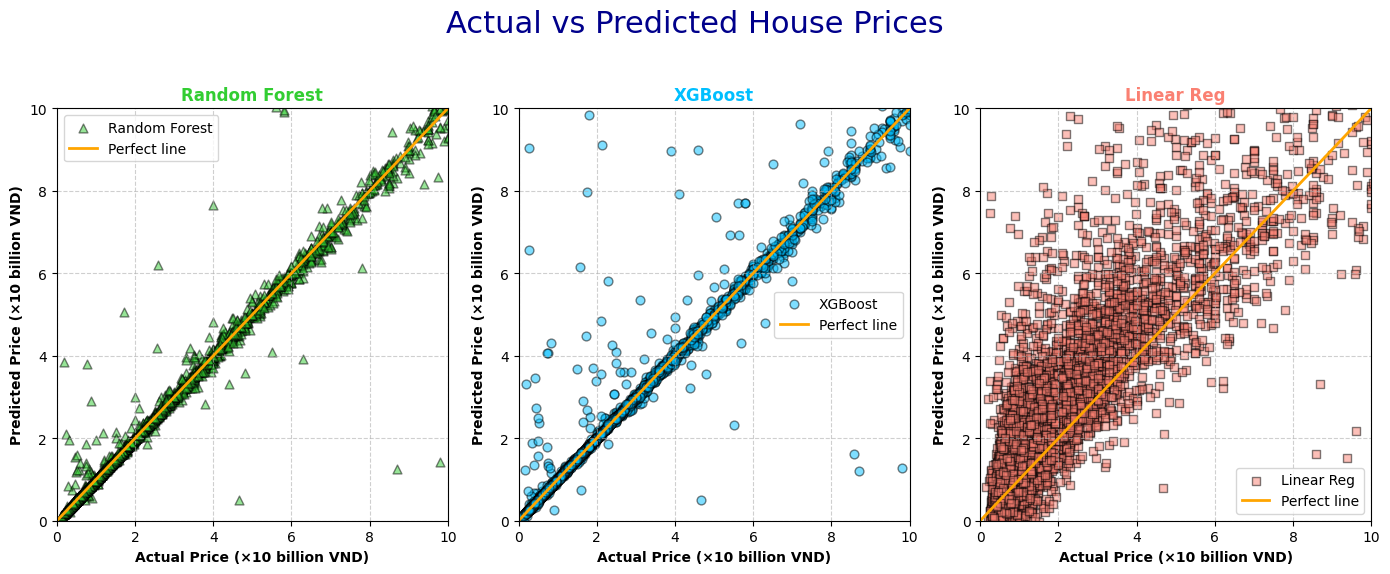

In [17]:
# -------------------------------------------------
# 8. MINH HỌA SCATTER ACTUAL vs PREDICTED
# -------------------------------------------------
import matplotlib.pyplot as plt

models = [("Random Forest", rf_pred, "limegreen",   "^"),
          ("XGBoost", xgb_pred, "deepskyblue", "o"),
          ("Linear Reg", lr_pred, "salmon", "s")]

plt.figure(figsize=(14,6))
for i, (name, pred, color, marker) in enumerate(models, 1):
    plt.subplot(1,3,i)
    plt.scatter(y_test/10, pred/10, c=color, marker=marker,
                s=40, edgecolors="black", alpha=0.5, label=name)
    plt.plot([0,10], [0,10], "orange", lw=2, label="Perfect line")
    plt.xlim(0,10); plt.ylim(0,10)
    plt.xlabel("Actual Price (×10 billion VND)", fontweight="bold")
    plt.ylabel("Predicted Price (×10 billion VND)", fontweight="bold")
    plt.title(name, fontweight="bold", color=color)
    plt.grid(ls="--", alpha=0.6); plt.legend()

plt.suptitle("Actual vs Predicted House Prices", fontsize=22, color="darkblue")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

In [18]:
# -------------------------------------------------
# 9. IMPORT THƯ VIỆN
# -------------------------------------------------

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
import numpy as np

In [19]:
# -------------------------------------------------
# 10. BASE MODEL (đều bọc trong pipeline có 'prep')
# -------------------------------------------------
rf_pipe = Pipeline([
        ("prep", preprocess),
        ("rf",  RandomForestRegressor(**study.best_params))
])

xgb_pipe = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**study.best_params))
])

lin_pipe = Pipeline([
        ("prep", preprocess),
        ("lr",   LinearRegression())
])

In [20]:
# -------------------------------------------------
# 10. META‑MODEL  (RidgeCV cho chắc chắn)
# -------------------------------------------------
meta_model = RidgeCV(alphas=np.logspace(-3,3,13))

In [21]:
# -------------------------------------------------
# 11. STACKING REGRESSION  (K=10 fold, shuffle)
# -------------------------------------------------
stack = StackingRegressor(
        estimators=[('rf', rf_pipe),
                    ('xgb', xgb_pipe),
                    ('lin', lin_pipe)],
        final_estimator=meta_model,
        cv=KFold(n_splits=10, shuffle=True, random_state=42),
        n_jobs=-1,
        passthrough=False    # chỉ dùng dự báo base model
)

In [22]:
# -------------------------------------------------
# 12. HUẤN LUYỆN
# -------------------------------------------------
stack.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:07:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[14:10:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[14:10:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[14:10:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[14:10:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[14:10:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "mi

StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('rf',
                               Pipeline(steps=[('prep',
                                                ColumnTransformer(transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 Index(['price_per_m2', 'area', 'floors', 'toilets', 'bedrooms', 'balcony',
       'street_frontage', 'legal', 'interior', 'year', 'month', 'day'],
      dtype='object')),
                                                                                ('bool',
                                                                                 'passthrough',
                                                                                 Index(['district...
       'district_ThanhXuan', 'district_ThuongTin', 'district_UngHoa'],
      dtype='object'))])),
                                               ('lr', LinearRegression())]))],
                  final_estimator=RidgeCV(alphas=array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])),
                  n_jobs=-1)

In [23]:
# -------------------------------------------------
# 13. ĐÁNH GIÁ DỰA TRÊN TẬP TEST
# -------------------------------------------------
pred_test = stack.predict(X_test)

rmse  = np.sqrt(mean_squared_error(y_test, pred_test))
rmsle = np.sqrt(mean_squared_log_error(
                    np.clip(y_test, 0, None)+1,
                    np.clip(pred_test, 0, None)+1))
r2    = r2_score(y_test, pred_test)

print(f"RMSE  : {rmse:,.3f}")
print(f"RMSLE : {rmsle:.3f}")
print(f"R²    : {r2:.4f}")

RMSE  : 19.712
RMSLE : 0.200
R²    : 0.8366


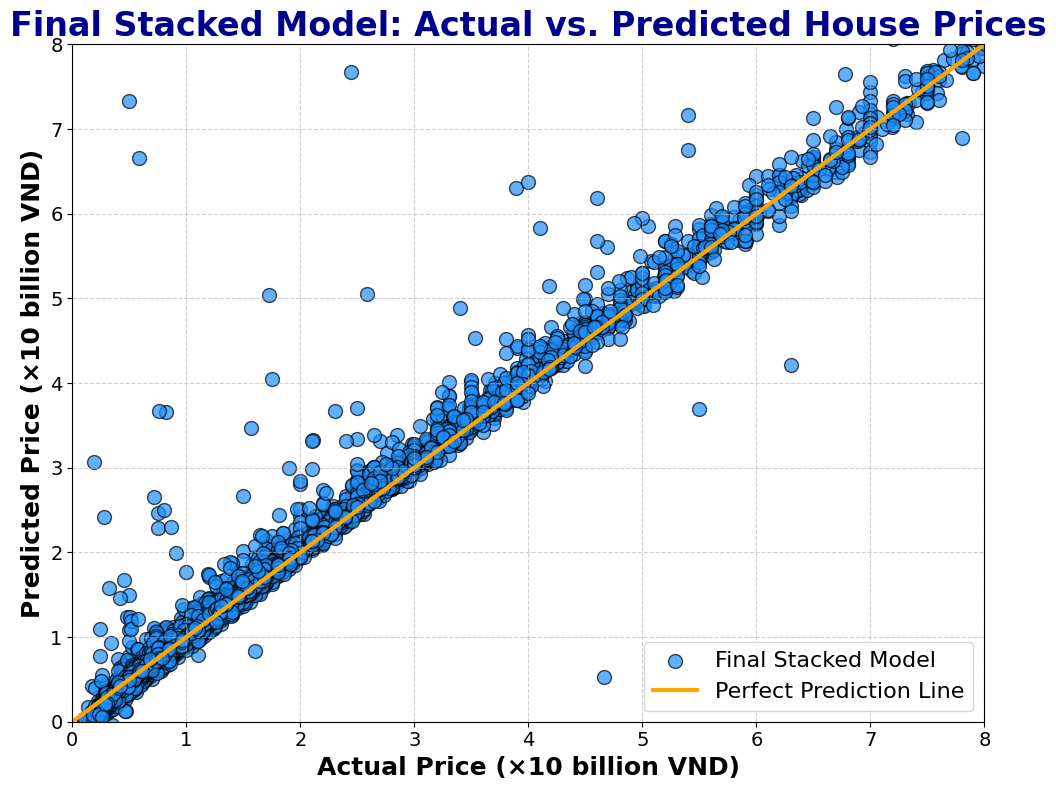

In [24]:
# -------------------------------------------------
# 14. VẼ SCATTER
# -------------------------------------------------
plt.figure(figsize=(10, 8))
plt.title("Final Stacked Model: Actual vs. Predicted House Prices", fontsize=24, fontweight='bold', color='darkblue')

plt.scatter(y_test / 10, pred_test / 10,
            color='dodgerblue', marker='o', edgecolors="black", alpha=0.7, s=100, label="Final Stacked Model")

plt.plot([0, 8], [0, 8], "orange", lw=3, label="Perfect Prediction Line")

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.xlabel("Actual Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.ylabel("Predicted Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
# -------------------------------------------------
# 15. TRIỂN KHAI
# -------------------------------------------------
deploy_pred = stack.predict(X_test)
pd.DataFrame({"Price": deploy_pred}) \
  .to_csv("Submission_Stack_(Rf+Xgb+Lr).csv", index=False)

print("Saved file: Submission_Stack_(Rf+Xgb+Lr).csv")

Saved file: Submission_Stack_(Rf+Xgb+Lr).csv
